<a href="https://colab.research.google.com/github/sansen405/AI-Object-Detection/blob/main/AI_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Download data and prepare environment { display-mode: "form" }

import matplotlib.pyplot as plt
import os
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers import concatenate, add
from keras.models import Model
import struct
import cv2
from copy import deepcopy

# Prepare data
DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)

# image_url = 'https://drive.google.com/uc?id=12ZpZ5H0kJIkWk6y4ktGfqR5OTKofL7qw'
# image_path = os.path.join(DATA_ROOT, 'image.jpg')
# gdown.download(image_url, image_path, True)
!wget -O /content/data/image.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image.jpg"

# image2_url = 'https://drive.google.com/uc?id=1_WpFbGEuS2r19UeP6wekbcF0kb-0nH18'
# image2_path = os.path.join(DATA_ROOT, 'image2.jpg')
# gdown.download(image2_url, image2_path, True)
!wget -O /content/data/image2.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg"

# video_url = 'https://drive.google.com/uc?id=1xFGjpzhZVYtNor9hJevvxysGESZJIMDz'
# video_path = os.path.join(DATA_ROOT, 'video1.mp4')
# gdown.download(video_url, video_path, True)
!wget -O /content/data/video1.mp4 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/6.mp4"

# model_url = 'https://drive.google.com/uc?id=19XKJWMKDfDlag2MR8ofjwvxhtr9BxqqN'
model_path = os.path.join(DATA_ROOT, 'yolo_weights.h5')
# gdown.download(model_url, model_path, True)
!wget -O /content/data/yolo_weights.h5 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/yolo.h5"

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union

def preprocess_input(image_pil, net_h, net_w):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image


def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = _sigmoid(netout[..., :2])
      netout[..., 4:]  = _sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w

          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]

              if((classes <= obj_thresh).all()): continue

              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height

              box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_yolo_boxes(boxes_all, image_h, image_w, net_h, net_w)

    return boxes_all

def correct_yolo_boxes(boxes_, image_h, image_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
    return boxes

def do_nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return

    for c in range(num_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1

        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                # print("{}: {}, ({}, {})".format(labels[i], box.classes[i]*100, box.xmin, box.ymin))
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)

    return new_boxes


from PIL import ImageDraw, ImageFont
import colorsys

def draw_boxes(image_, boxes, labels):
    image = image_.copy()
    image_w, image_h = image.size
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
                    size=np.floor(3e-2 * image_h + 0.5).astype('int32'))
    thickness = (image_w + image_h) // 300

    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.

    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        predicted_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        #label_size = draw.textsize(label)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(image_w, np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        #draw.text(text_origin, label, fill=(0, 0, 0))
        del draw
    return image

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


The type of the saved image is <class 'PIL.JpegImagePlugin.JpegImageFile'>


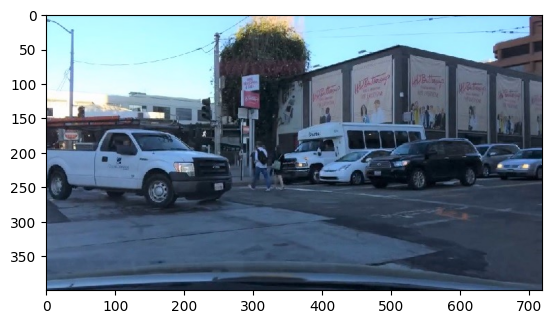

In [ ]:
from PIL import Image
from matplotlib import  pyplot as plt

image_path = '/content/data/image.jpg'

image_pil = Image.open(image_path)
image_w, image_h = image_pil.size
print("The type of the saved image is {}".format(type(image_pil)))
plt.imshow(image_pil)
plt.show()

Image Preprocessing

In [ ]:
net_h = 416
net_w = 416
new_image = preprocess_input(image_pil, net_h, net_w)

In [ ]:
plt.imshow(new_image[0])
plt.show()

DarkNet Architecture




<img src="https://miro.medium.com/max/2000/1*d4Eg17IVJ0L41e7CTWLLSg.png" width="1000"/>







In [ ]:
import tensorflow as tf

# Load model
darknet = tf.keras.models.load_model(model_path)

In [ ]:
yolo_outputs = darknet.predict(new_image)

len(yolo_outputs)

print(yolo_outputs[0].shape)
print(yolo_outputs[1].shape)
print(yolo_outputs[2].shape)



Post-processing for bounding box prediction

In [ ]:
obj_thresh = 0.4
nms_thresh = 0.45

In [ ]:
boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)

boxes = do_nms(boxes, nms_thresh, obj_thresh)

image_detect = draw_boxes(image_pil, boxes, labels)
plt.imshow(image_detect)



Non-Maximal Suppression

In [ ]:
boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)
image_detect = draw_boxes(image_pil, boxes, labels)
plt.imshow(image_detect)

Image Detection Function

In [ ]:
def detect_image(image_pil, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
  new_image = preprocess_input(image_pil, net_h, net_w)
  yolo_outputs = darknet.predict(new_image)

  image_w, image_h = image_pil.size

  boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)

  boxes = do_nms(boxes, nms_thresh, obj_thresh)

  image_detect = draw_boxes(image_pil, boxes, labels)
  return image_detect


In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(detect_image(image_pil))
plt.show()




Detection on Videos

In [ ]:
import cv2

def detect_video(video_path, output_path, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'mp4v')
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

    num_frame = 0
    while vid.isOpened():
      ret, frame = vid.read()
      num_frame += 1
      print("=== Frame {} ===".format(num_frame))
      if ret:
          new_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          new_frame = detect_image(new_frame)

          new_frame = cv2.cvtColor(np.asarray(new_frame), cv2.COLOR_RGB2BGR)
          out.write(new_frame)
      else:
          break
    vid.release()
    out.release()
    print("New video saved!")

In [ ]:
video_path = '/content/data/video1.mp4'
output_path = '/content/data/video1_detected.mp4'
detect_video(video_path, output_path)